# Genetic Algorithms with DEAP

Source: [Kevin Sikorski](https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/genetic-algorithms-with-deap.ipynb)

In this lab, we will first learn how to use a simple and easy-to-use implementation of a Genetic Algorithm using DEAP library in Python.
Then you'll write code that optimised position in artificial landscapes, use GA on a simple neuralnet to control a game, and use Hebbian Learning to implement simple logic gates.

# Terminology

### Individual
Genetic Algorithms make use of an analogy to genetics, where we use a population of randomly generated individuals, each with some genetic code.  This code represents a potential solution to the problem.  The representation of the solution depends on the particular problem we are addressing, but it generally consists of a data structure.  It could contain one or more strings like "ACGTCACTCGGATGC" if we are dealing with DNA, real-valued data if we are dealing with vectors, arbitrary and mutually-exclusive concepts like "January", "February", and "December", or anything else. 

### Fitness 
Since these solutions are chosen at random, some are better than others.  We need to be able to evaluate how good a particular solution is.  We do this by defining a fitness function (called an evaulation function in the example below).  This takes in an individual or its genetic code, and outputs a scalar number that allows us to compare fitness between individuals.

### Mutation
In the real world, genetic code mutates due to random events like cosmic rays and nuclear decay, or due to random transcription errors.  We simulate this in genetic algorithms with a mutation rate.  Here with a low probability, we randomly change one or more elements of the genetic code of an individual.  This might be changing a number encoded in it (either a little or a lot), flipping a bit in a string, or randomizing the month in a date-time field.

### Crossover
In the real world, mating between individuals produces offspring with genetic code that is a combination of the parents.  This is simulated with crossover.  In the first diagram below we show two parents at the top, each with different genetic material.  Two offspring are shown below, each the product of crossover.  The parent's genetic code is broken at a randomly selected point.  The right half of the red parent is attached to the left half of the blue parent to produce one offspring's genes; the remaining pieces are similarly concatenated to make the other offspring's genes.

Geometrically, you can think of crossover as a projection of one parent's genetic code to a random plane in the search space that contains the other parent's genetic code.  (This plane will also be aligned with one of the basis vectors of the genetic code.)  The Crossover as projection diagram below shows an example involving two parents in magenta with genetic code (0,0) and (1,1).  When crossover occurs, we produce the cyan individuals with genetic code (0,1) and (1,0) by taking the first element from one parent and the second element from the second parent.  Or phrased geometrically, by projecting one parent's point to the Y-axis (the basis vector for the second element of the genetic code), and the the other parent's point to the X-axis.

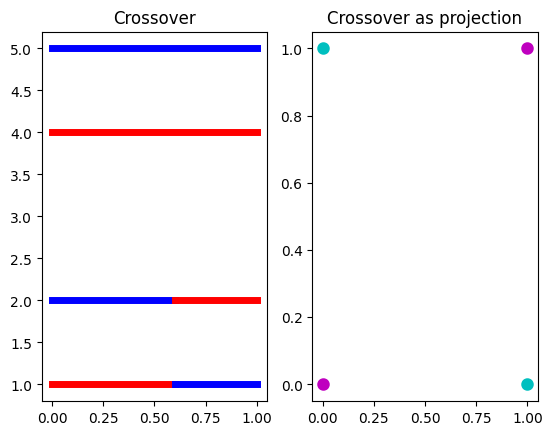

In [1]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.title("Crossover")
fig=plt.plot((0, 1), (5, 5), linewidth=5, color='b')
fig=plt.plot((0, 1), (4, 4), linewidth=5, color='r')
fig=plt.plot((0, 0.6), (2, 2), linewidth=5, color='b')
fig=plt.plot((0, 0.6), (1, 1), linewidth=5, color='r')
fig=plt.plot((0.6, 1), (1, 1), linewidth=5, color='b')
fig=plt.plot((0.6, 1), (2, 2), linewidth=5, color='r')

plt.subplot(1,2,2)
plt.scatter([0, 1], [0,1], color='m', lw=3)
plt.scatter([1, 0], [0,1], color='c', lw=3)
plt.title("Crossover as projection")

plt.show()

# One Max Problem
This example will help new users to overview some of the DEAP framework’s possibilities and illustrate the potential of evolutionary algorithms in general. The problem itself is both very simple and widely used in the evolutionary computational community. We will create a population of individuals consisting of integer vectors randomly filled with 0 and 1. Then we let our population evolve until one of its members contains only 1 and no 0 anymore.


In [2]:
import random

#!pip install deap
from deap import base
from deap import creator
from deap import tools
  

## Creator
Since the actual structure of the required individuals in genetic algorithms does strongly depend on the task at hand, DEAP does not contain any explicit structure. It will rather provide a convenient method for creating containers of attributes, associated with fitnesses, called the deap.creator. Using this method we can create custom individuals in a very simple way.

The creator is a class factory that can build new classes at run-time. It will be called with first the desired name of the new class, second the base class it will inherit, and in addition any subsequent arguments you want to become attributes of your class. This allows us to build new and complex structures of any type of container from lists to n-ary trees.

In [3]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

First we will define the class FitnessMax. It will inherit the Fitness class of the deap.base module and contain an additional attribute called weights. Please mind the value of weights to be the tuple (1.0,). This way we will be maximizing a single objective fitness. We can’t repeat it enough, in DEAP single objectives is a special case of multi objectives.

Next we will create the class Individual, which will inherit the class list and contain our previously defined FitnessMax class in its fitness attribute. Note that upon creation all our defined classes will be part of the creator container and can be called directly.

## Toolbox
Now we will use our custom classes to create types representing our individuals as well as our whole population.

All the objects we will use on our way, an individual, the population, as well as all functions, operators, and arguments will be stored in a DEAP container called Toolbox. It contains two methods for adding and removing content, register() and unregister().

In [4]:
toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In this code block we register a generation function toolbox.attr_bool() and two initialization ones individual() and population(). toolbox.attr_bool(), when called, will draw a random integer between 0 and 1. The two initializers, on the other hand, will instantiate an individual or population.

The registration of the tools to the toolbox only associates aliases to the already existing functions and freezes part of their arguments. This allows us to fix an arbitrary amount of argument at certain values so we only have to specify the remaining ones when calling the method. For example, the attr_bool() generator is made from the randint() function that takes two arguments a and b, with a <= n <= b, where n is the returned integer. Here, we fix a = 0 and b = 1.

Our individuals will be generated using the function initRepeat(). Its first argument is a container class, in our example the Individual one we defined in the previous section. This container will be filled using the method attr_bool(), provided as second argument, and will contain 100 integers, as specified using the third argument. When called, the individual() method will thus return an individual initialized with what would be returned by calling the attr_bool() method 100 times. Finally, the population() method uses the same paradigm, but we don’t fix the number of individuals that it should contain.

## The Evaluation Function
The evaluation function is pretty simple in our example. We just need to count the number of ones in an individual.

In [5]:
def evalOneMax(individual):
    return sum(individual),
  
print(evalOneMax([0,0,0,0]))
print(evalOneMax([0,1,0,1]))
print(evalOneMax([1,1,1,1]))

(0,)
(2,)
(4,)


## The Genetic Operators
Within DEAP there are two ways of using operators. We can either simply call a function from the tools module or register it with its arguments in a toolbox, as we have already seen for our initialization methods. The most convenient way, however, is to register them in the toolbox, because this allows us to easily switch between the operators if desired. The toolbox method is also used when working with the algorithms module. See the [One Max Problem: Short Version](https://deap.readthedocs.io/en/master/examples/ga_onemax_short.html#short-ga-onemax) for an example.

Registering the genetic operators required for the evolution in our One Max problem and their default arguments in the toolbox is done as follows.

In [6]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

The evaluation will be performed by calling the alias evaluate. It is important to not fix its argument in here. We will need it later on to apply the function to each separate individual in our population. The mutation, on the other hand, needs an argument to be fixed (the independent probability of each attribute to be mutated indpb).

## Evolving the Population
Once the representation and the genetic operators are chosen, we will define an algorithm combining all the individual parts and performing the evolution of our population until the One Max problem is solved.

## Creating the Population
First of all, we need to actually instantiate our population. But this step is effortlessly done using the population() method we registered in our toolbox earlier on.

In [7]:
pop = toolbox.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit


**pop** will be a list composed of 300 individuals. Since we left the parameter **n** open during the registration of the population() method in our toolbox, we are free to create populations of arbitrary size.

Before we go on, this is the time to define some constants we will use later on.

In [8]:
# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.5, 0.2

## Evaluating the Population
The next thing to do is to evaluate our brand new population.  We map() the evaluation function to every individual and then assign their respective fitness. Note that the order in fitnesses and population is the same.

The evolution of the population is the final step we have to accomplish. Recall, our individuals consist of 100 integer numbers and we want to evolve our population until we got at least one individual consisting of only 1s and no 0s. So all we have to do is to obtain the fitness values of the individuals!

To check the performance of the evolution, we will calculate and print the minimal, maximal, and mean values of the fitnesses of all individuals in our population as well as their standard deviations.

In [9]:
def findFitness():
    fits = [ind.fitness.values[0] for ind in pop]
        
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
    return fits
    
fits=findFitness()

  Min 39.0
  Max 63.0
  Avg 49.63666666666666
  Std 4.7326513593216815


## Mating and Mutation

In genetic algorithms, evolution occurs via either mutation or crossover, both of which happen (or don't happen) randomly.  In mutation, we change one or more of the genes of one of our individuals.  In cross-over, two individuals are mated to mix their genes.

The crossover (or mating) and mutation operators, provided within DEAP, usually take respectively 2 or 1 individual(s) as input and return 2 or 1 modified individual(s). In addition they modify those individuals within the toolbox container and we do not need to reassign their results.

We will perform both the crossover (mating) and the mutation of the produced children with a certain probability of CXPB and MUTPB. The del statement will invalidate the fitness of the modified offspring.

In [10]:
def mateAndMutate(offspring):
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            


## The Main Loop

This will creates an offspring list, which is an exact copy of the selected individuals. The toolbox.clone() method ensure that we don’t use a reference to the individuals but an completely independent instance. This is of utter importance since the genetic operators in toolbox will modify the provided objects in-place.

We then mutate and mate the individuals to find the next generation of individuals.  We evaluate them, and continue until one of our individuals evolves to be the perfect organism (fitness of 100 or more), or until the number of generations reaches 1000.

At each generation, we output some statistics about that generation's population, as well as a graph of the genetic material for an arbitrary individual.  A 0 in the genetic material is drawn in red, and a 1 is drawn in blue.

In [11]:
import numpy as np
# Variable keeping track of the number of generations
g = 0

# Begin the evolution
while max(fits) < 100 and g < 1000:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    
    # Apply crossover and mutation on the offspring
    mateAndMutate(offspring)
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    pop[:] = offspring
    
    # print statistics on our updated population
    fits=findFitness()

    # plot an arbitrary organism
    x = [i/100 for i in range(len(pop[0]))]
    y = [1 for i in x]
    colors = ['r' if pop[0][i]==0 else 'b' for i in range(len(pop[0]))]
    #plt.scatter(x, y, c=colors, alpha=0.5)
    #plt.show()
#plt.scatter(x,y, c=colors, alpha=.5)
#plt.show()

-- Generation 1 --
  Min 41.0
  Max 69.0
  Avg 53.68333333333333
  Std 3.933156775698443
-- Generation 2 --
  Min 46.0
  Max 70.0
  Avg 56.903333333333336
  Std 3.928611572666418
-- Generation 3 --
  Min 50.0
  Max 70.0
  Avg 60.05
  Std 3.7399866309921728
-- Generation 4 --
  Min 53.0
  Max 72.0
  Avg 62.95666666666666
  Std 3.4940123385905144
-- Generation 5 --
  Min 55.0
  Max 73.0
  Avg 65.74666666666667
  Std 3.1009389259097073
-- Generation 6 --
  Min 61.0
  Max 74.0
  Avg 67.95
  Std 2.3946120075423845
-- Generation 7 --
  Min 61.0
  Max 76.0
  Avg 69.35
  Std 2.5167770395226414
-- Generation 8 --
  Min 63.0
  Max 77.0
  Avg 70.90333333333334
  Std 2.5246759968139596
-- Generation 9 --
  Min 65.0
  Max 78.0
  Avg 72.48
  Std 2.3614120069708324
-- Generation 10 --
  Min 65.0
  Max 80.0
  Avg 73.88
  Std 2.470951233837037
-- Generation 11 --
  Min 64.0
  Max 81.0
  Avg 75.39333333333333
  Std 2.2476555687107758
-- Generation 12 --
  Min 67.0
  Max 85.0
  Avg 76.53666666666666
  St

# Your tasks:
This lab *is* fairly open-ended. I look forward to seeing what you come up with:

## 1. Find optimum with ES.
Chose an [artificial landscape](https://en.wikipedia.org/wiki/Test_functions_for_optimization). Find optimum using an evolutionary strategy we talked about in class.

In [12]:
# Artifical landscape
import random
import sys
#from statistics import variance

def booth_function(x, y):
  return (x+2*y-7)**2 + (2*x+y-5)**2

def matyas_function(x, y):
  return 0.26 * (x**2 + y**2) - 0.48*x*y

def points_mean(points):
  sums = []
  sum_x = 0
  sum_y = 0
  n = len(points)
  for i in range(n):
    sum_x += points[i][0]
    sum_y += points[i][1]
  return (sum_x/n, sum_y/n)

def points_variance(points, mean):
  var_x = 0
  var_y = 0
  mean_x = mean[0]
  mean_y = mean[1]
  n = len(points)
  for i in range(n):
    xi = points[i][0]
    yi = points[i][1]
    var_x += (xi - mean_x)**2
    var_y += (yi - mean_y)**2

  var_x /= n
  var_y /= n
  return (var_x, var_y)

def fitness(points, landscape):
  p_min = sys.maxsize
  i_best = -1
  for i in range(len(points)):
    xi = points[i][0]
    yi = points[i][1]
    v = landscape(xi, yi)
    if v < p_min:
      p_min = v
      i_best = i
  return points[i_best]


def generate_points(n, spread, mean):
  points = []
  for i in range(n):
    p = (((random.random() - 0.5) * spread) + mean[0], 
         ((random.random() - 0.5) * spread) + mean[1])
    points.append(p)
  return points

#landscape = booth_function

# Simple evolutionary algorithm
def SES(n, landscape, iter=100):
  # generate random points

  o_spread = 0.1
  spread = o_spread
  points = generate_points(n, spread, (0,0))

  best = None

  for i in range(iter):
    best = fitness(points, landscape)
    p_mean = best

    points = generate_points(n, spread, p_mean)
    p_var = points_variance(points, p_mean)
    spread = o_spread * (iter-i)/iter
  
  return best

#print(SES(10))

SES(100, booth_function, iter=1000)
#SES(100, matyas_function, iter=10000)

#print(landscape(2,3))



(1.0000072713295265, 2.9999772613808937)

## 2. Evolve a simple gaming neural net with GA.
Evolve a neural network that plays a game of your choice from `gym` (LunarLander-v2 is cool).
We don't need `torch` since we don't care about gradients. We can use numpy—numpy matrices can easily be multiplied.
`deap` *can* deal with numpy arrays, though I recommend making functions that map weights to lists and vice versa.

In [13]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from gym.utils.play import play
from deap import base
from deap import creator
from deap import tools

# CXPB  is the probability with which two individuals
#       are crossed
# 
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.5, 0.5

gauss, flip = 0.5, 0.1

n_individuals = 300
env = gym.make("LunarLander-v2", continuous = False)

input, output = env.observation_space.shape[0], env.action_space.n

def network(ind):
    l1_out = 32
    l1 = np.random.rand(input, l1_out) 
    l2 = np.random.rand(l1_out, output)
    layers = [l1, l2]
    return ind(layers)

def get_action(individual, obs):
    individual = np.array(individual)
    mut = np.matmul(individual[0], individual[1])
    return np.argmax(np.matmul(mut.T, obs))

def eval_lunar_lander(ind):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done and steps < 300:
        action = get_action(ind, obs)
        next_state, reward, done, _, _ = env.step(action)
        obs = next_state
        total_reward += reward
        steps += 1

    return total_reward,

def run_normal(ind):
    env2 = gym.make("LunarLander-v2", continuous = False, render_mode='human')
    obs, _ = env2.reset()
    done = False
    steps = 0
    while not done and steps < 300:
        env2.render()
        action = get_action(ind, obs)
        next_state, reward, done, _, _ = env2.step(action)
        obs = next_state
        steps += 1

    env2.close()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()    

toolbox.register("individual", network, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", eval_lunar_lander)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def findFitness(pop):
    fits = [ind.fitness.values[0] for ind in pop]
        
    length = len(pop)
    mean = sum(fits) / length
    fits.sort()
    mid = fits[int(len(fits)/2)]
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    #print("  Avg %s" % mean)
    print("  Median %s" % mid)
    print("  Std %s" % std)
    return fits


def mutate(offspring):
    for ind in offspring:
        if random.random() < flip:
            for layer in ind:
                for node in layer:
                    toolbox.mutate(node)
                    #tools.mutFlipBit(indpb=0.2)
            del ind.fitness.values
        if random.random() < gauss:
            tools.mutGaussian(ind, 0.0, 0.2, 0.5)
            del ind.fitness.values

def mate(offspring):
    children = []
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            child = toolbox.mate(child1, child2)
            children.append(child)
            del child1.fitness.values
            del child2.fitness.values

    return children

def train_SGA(n, g_limit):
    pop = toolbox.population(n)

    for i in range(n):
        fit = toolbox.evaluate(pop[i])
        pop[i].fitness.values = fit

    plt.ion()
    plt.show()
    plt.xlabel('generation')
    plt.ylabel('median score')
    plt.title('Lunar lander')
    x = []
    y = []

    for g in range(g_limit):

        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        mutate(offspring)
        mate(offspring)

        # Evaluate population
        max_fitness_index = -1
        max_fitness = -1000

        for i in range(n):
            fit = toolbox.evaluate(offspring[i])
            if fit[0] > max_fitness:
                max_fitness_index = i
                max_fitness = fit[0]
            offspring[i].fitness.values = fit

        #Run with best AI
        best = offspring[max_fitness_index]
        for i in range(3):
            run_normal(best)

        pop[:] = offspring



        print("Generation: ", g)
        fits=findFitness(pop)

        x.append(g)
        y.append(fits[int(len(fits)/2)])
        #y.append(sum(fits) / len(fits))
        plt.plot(x, y)

        plt.draw()
        plt.pause(0.1)


train_SGA(n_individuals, 1000)

c:\Python\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Python\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\patri\AppData\Local\Temp\ipykernel_5832\935614861.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  individual = np.array(individual)


Generation:  0
  Min -2437.755349940795
  Max 64.449019965617
  Median -304.94800874177406
  Std 315.2096970606449
Generation:  1
  Min -2750.512161834245
  Max 267.5234449827743
  Median -205.71785792945496
  Std 271.8354888282122
Generation:  2
  Min -2484.962176855349
  Max 91.94163412772707
  Median -177.06106747744082
  Std 275.5186533552894
Generation:  3
  Min -1524.04379938393
  Max 244.96899630510202
  Median -167.31903688854914
  Std 217.12571377349727


KeyboardInterrupt: 

: 

## 3. Implement Hebbian Learning on AND and OR logic gates.
Make functions that given an input of the kind `[1,1,0]`, `[0,0,0]`, etc.:
1. Returns 1 if input is all ones, otherwise 0 (AND).
2. Returns 1 if at least one element is 1, otherwise 0 (OR).
3. Optional: XOR.

In [ ]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from gym.utils.play import play
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("individual", network, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", eval_lunar_lander)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

c:\Python\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Python\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
def generate_input(pair_size, pair_count):
    input = np.random.randint(low= 0, high=2, size=(pair_count, pair_size))

    return input

def generate_target_and(input):
    pair_count = input.shape[0]
    pair_size = input.shape[1]

    target = np.zeros(pair_count)
    for i in range(pair_count):
        is_one = True
        for j in range(pair_size):
            is_one &= input[i, j]
            if not is_one:
                break
        if is_one:
            target[i] = 1
        else:
            target[i] = 0

    return target

def generate_target_or(input):
    pair_count = input.shape[0]
    pair_size = input.shape[1]

    target = np.zeros(pair_count)
    for i in range(pair_count):
        for j in range(pair_size):
            if input[i, j]:
                target[i] = 1
                break

    return target

def test_hebbian_and(input, target, weights, bias):
    
    success = True
    for i in range(input.shape[0]):
        x = input[i]
        y = np.matmul(x, weights)
        y = y + bias
        if y > 0:
            y = 1
        else:
            y = 0

        t = target[i]

        if y != t:
            success = False
            break

    print("AND success: ", success)
    
def test_hebbian_or(input, target, weights, bias):

    success = True
    for i in range(input.shape[0]):
        x = input[i]
        y = np.matmul(x, weights)
        y = y + bias
        t = target[i]
        #print(y)
        #print(t)
        if y > 0:
            y = 1
        else:
            y = 0
        
        if y != t:
            success = False
            break

    print("OR success: ", success)

def hebbian_and(input, target):
    w = np.zeros((input.shape[1]))
    b = -1
    
    for i in range(input.shape[0]):
        x = input[i]
        y = target[i]
        w = w + x*y
        b = b - 2*y

    return (w, b)

def hebbian_or(input, target):
    w = np.zeros((input.shape[1]))
    b = 0

    for i in range(input.shape[0]):
        x = input[i]
        y = target[i]
        w = w + x*y
        b = b

    return (w, b)

input_training = generate_input(3, 100)
target_training_and = generate_target_and(input_training)
target_training_or = generate_target_or(input_training)

weights_and, bias_and = hebbian_and(input_training, target_training_and)
weights_or, bias_or = hebbian_or(input_training, target_training_or)

input_test = generate_input(3, 1000)
target_test_and = generate_target_and(input_test)
target_test_or = generate_target_or(input_test)

test_hebbian_and(input_test, target_test_and, weights_and, bias_and)
test_hebbian_or(input_test, target_test_or, weights_or, bias_or)

AND success:  True
OR success:  True


## Optional (and awesome): Do Hebbian Learning over Reinforcement Learning for the Lunar Lander from gym (LunarLander-v2).
![](https://www.gymlibrary.dev/_images/lunar_lander.gif)

In [ ]:
# Your code